In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numba
import math
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import progressbar # pip install progressbar2
import plotly.offline as py
import plotly.graph_objs as go
import os
import sys
from numba import jit, njit
sys.path.append("../../")
import helpers

# Init plotly
py.init_notebook_mode()

%load_ext autoreload
%autoreload 2

# 3D Reconstruction
In this notebook we look at generating a virtual representation from a set of (real world) images. Given a collection of images from different angles the aim is to create a 3D reconstruction of the scene that the images capture. Common use cases include augmented reality, [virtual cameras](https://www.youtube.com/watch?v=J7xIBoPr83A) and [photogrammetry](https://www.youtube.com/watch?v=wnt64H-Wouk).

## Pipeline
Estimating the camera matrix is the first step of 3D reconstruction. As you learned in the previous notebook we can compute the camera matrix given a list of known pixels/3D point pairs. In real-world photogrammetry software this process is completely automated. However this gives us only a very sparse representation: typically only a couple hundred points for images with millions of pixels. In this notebook we will compute a 3D point for each pixel in the image, assuming that the camera matrices are already known.

### Setup
For all the following exercises we will use the data set that is made publicly available by [ETH Zurich](https://www.eth3d.net/datasets). This data set already includes the camera matrices as well as a set the set of 3D points and their location in the images. The following code loads 2 images looking at the same object from different angles, including the camera matrices and the set of 3D points used to compute these matrices (displayed as colored dots).

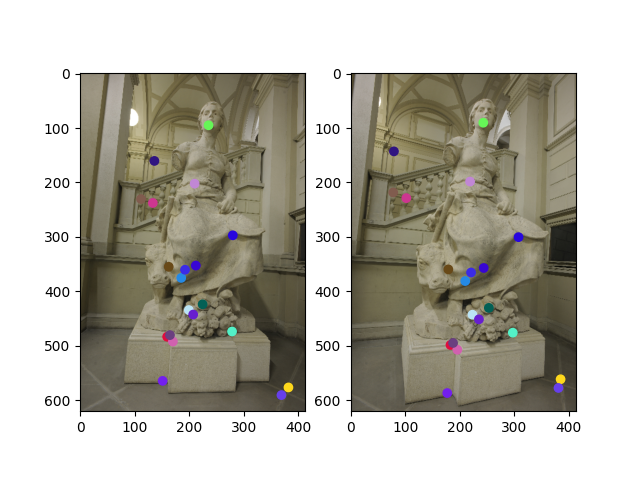

In [2]:
import mvs
import eth3d_loader
import glm

try:
    glm.vec2(2)
except:
    print("================")
    print("===== Error ====")
    print("================")
    print("It seems like pyglm could not be accessed.") 
    print("This is most commonly caused by having both the \"pyglm\" and \"glm\" libraries installed at the same time.")
    print("These libraries are incompatible with eachother because both use \"import glm\"")
    print("Please check in Anaconda Navigator that pyglm IS installed and glm IS NOT installed, then restart the notebook (Kernel -> Restart Kernel)")

# https://www.eth3d.net/datasets
# https://www.eth3d.net/documentation#camera-models-pinhole-camera-model
points3D, (camera0, camera1), (image0, image1), (points2D_0, points2D_1) = eth3d_loader.load_eth3d_dataset(
    os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "eth3d", "statue"), ["4", "5"], scale=0.1, swap_uv=True)
_, (camera0_low_res, camera1_low_res), (image0_low_res, image1_low_res), _ = eth3d_loader.load_eth3d_dataset(
    os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "eth3d", "statue"), ["4", "5"], scale=0.05, swap_uv=True)

# Convert from list of glm.vec3 to Numpy format.
points2D_0_np = np.array(points2D_0)
points2D_1_np = np.array(points2D_1)
# Generate random colors.
colors = np.random.rand((len(points2D_1_np)), 3)

num_points_to_show = 20
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image0)
ax1.scatter(points2D_0_np[:num_points_to_show, 0], points2D_0_np[:num_points_to_show, 1], c=colors[:num_points_to_show])
ax2.imshow(image1)
ax2.scatter(points2D_1_np[:num_points_to_show, 0], points2D_1_np[:num_points_to_show, 1], c=colors[:num_points_to_show])

## Camera location and references points
The following 3D plot illustrates the location of the two cameras relative to each other as well as to the statue. The known 3D points (part of the dataset) are plotted as orange dots.

In [3]:
mvs.plot_cameras_3D(image0, camera0, camera1, points3D)

## Triangulating matching view rays
Each pixel defines a ray in 3D space. A ray is a half open light segment: it starts at the camera and it goes through the pixel towards infinity. A ray is defined by the following formula: $\vec{p}=\vec{o}+t\vec{d}$. Here, $\vec{o}$ is the origin (starting point) and $\vec{d}$ is the direction of the ray. The direction vector is normalized $\lvert \vec{d} = 1\rvert$ such that $t$ describes the length of the ray.

If we know that two pixels are looking at the same point in 3D then it is possible to compute the position of that 3D point based on the pixel coordinates in both images. Imagine the two rays corresponding to the matching pixels: one starting from `camera0` and the other at `camera1`. The rays will intersect at that point in 3D space. However due to various sources of error (discretization and computer arithmatic) it is very uncommon for two rays to exactly intersect. So instead we find the closest point half-way between the two rays.

Given two rays $\vec{p}=\vec{o_p}+t_p\vec{d_p}$ and $\vec{q}=\vec{o_q}+t_q\vec{d_q}$ we want to find the closest point between them. Two rays are closest when the line segment between $p$ and $q$ ($\vec{pq} = \vec{q} - \vec{p}$) is orthogonal to both rays: $\vec{d_p} \cdot pq = 0$ and $\vec{d_q} \cdot pq = 0$.

$$
\begin{align}
\vec{d_p} \cdot pq &= 0 \text{ and } \vec{d_q} \cdot pq = 0 \\
\vec{d_p} \cdot (\vec{o_q} + t_q\vec{d_q} - \vec{o_p} - t_p\vec{d_p}) &= 0 \text{ and } \vec{d_q} \cdot (\vec{o_q} + t_q\vec{d_q} - \vec{o_p} - t_p\vec{d_p}) = 0 \\
\vec{d_p}\cdot\vec{d_q}t_q - \vec{d_p}\cdot\vec{d_p}t_p &= \vec{o_p}\cdot\vec{d_p} - \vec{o_q}\cdot\vec{d_p} \text{ and } \vec{d_q}\cdot\vec{d_q}t_q - \vec{d_p}\cdot\vec{d_q}t_p = \vec{o_p}\cdot\vec{d_q} - \vec{o_q}\cdot\vec{d_q} \\
... &= ...
\end{align}
$$

### GLM library
In the following exercises we will be using the `glm` library to store our three dimensional vectors (`glm.vec3`) rather than `numpy` due to performance reasons. These work the exact same way as `numpy` arrays (element wise operations) and are interoperable with `numpy` (you can call `numpy` functions such as `np.dot` on a `glm.vec3`).

### Exercise 4 (2 points)
Derive the exact solution to $t_p$ and $t_q$ by hand using the formula above as a starting point. Then implement a function that uses this derivation to compute the values for $p$ and $q$.

Calling `np.linalg.lstsq` (or similar function) is not allowed.

In [4]:
# Find the closest points p and q on ray 0 and ray 1
def closest_points_on_rays(ray0, ray1):
    o0, d0 = ray0
    o1, d1 = ray1
    
    # TODO: Compute the point p on ray0 which is closest to ray1; Similarly, compute the point q on ray1 which is closest to ray0.
    p = o0
    q = o1
    # YOUR CODE HERE
    return (p, q)

# Find the closest point between both rays (half way between p and q)
def closest_point_between_rays(ray0, ray1):
    p, q = closest_points_on_rays(ray0, ray1)
    return (p + q) / 2

### Test of exercise 4
We provide some code to help you verify your solution. As part of the provided dataset we obtain a set of 3D points that are known to lie on the surface of the object. Each such point maps to a different pixel in both images. We shoot a ray for each camera "through" their respective pixel and call your function to find the 3D location where they intersect. Your computed 3D point should be very close to the actual known 3D point position.

The graph plots the percentage of points which have an error (in centimeters) smaller than the value indicated on the horizontal axis. *Your solution should be accurate to 10cm.*

In [5]:
# Add your own tests here.

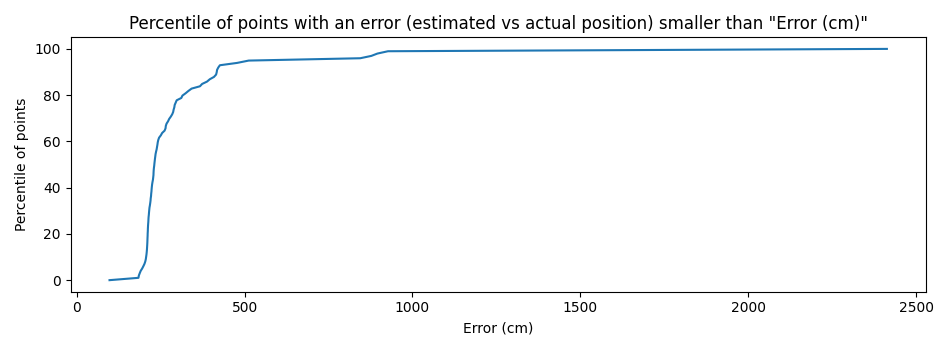

In [6]:
triangulation_errors = []
for pixel0, pixel1, ref_point3D in zip(points2D_0, points2D_1, points3D):
    ray0 = mvs.pixel_to_ray(camera0, pixel0)
    ray1 = mvs.pixel_to_ray(camera1, pixel1)
    point3D = closest_point_between_rays(ray0, ray1)
    triangulation_errors.append(glm.length(point3D - ref_point3D))

x = np.linspace(0, 100, 100)
y = np.percentile(triangulation_errors, x)

fig, ax = plt.subplots(figsize=helpers.default_fig_size)
ax.set_title("Percentile of points with an error (estimated vs actual position) smaller than \"Error (cm)\"")
ax.set_xlabel("Error (cm)")
ax.set_ylabel("Percentile of points")
ax.plot(y*100, x)
fig.tight_layout()
plt.show()

In [7]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Epipolar lines
To create a 3D reconstruction from two images we have to find matching pixel pairs. Comparing each pixel in one image with each pixel in the other image is not only inefficient but might also lead to matches who's rays do not get close to intersecting.

By projecting the ray from one camera into the image of the other camera we can guarantee that we only consider pixels with intersecting rays. The projection of the ray becomes a line in the other image which we refer to as an *epipolar line*.

The demo below allows you to interactively visualize the epipolar line. **Click anywhere in the left image** to select a pixel. The matching epipolar line will be drawn in the right image. Verify that the epipolar line indeed crosses the 3D point that you clicked in the left image.

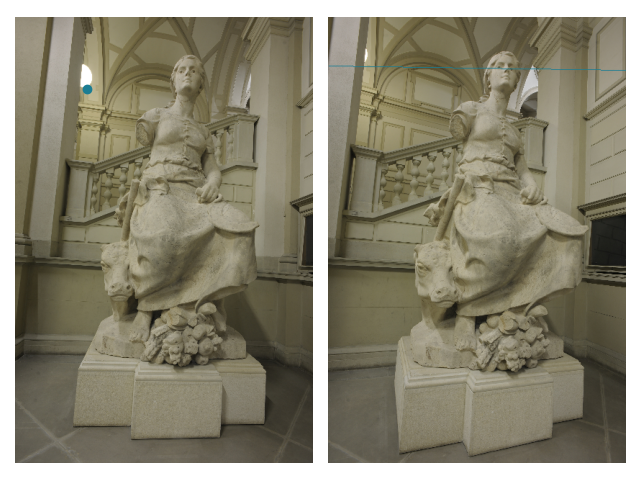

In [8]:
mvs.plot_interactive_epipolar_lines(image0, image1, camera0, camera1)

## Photo consistency measures
To detect which pixels are seeing the same 3D point, we need a way of expressing the similarity between two pixels (in two different images). A single pixel (3 values in RGB) does not capture enough information to find the correct match out of thousands of potential pixels. Instead we look at a little square patch around the pixel of interest (similar to examplar based inpainting).

A photo consistency measure is a function that compares two patches and returns a score indicating how similar they are.  The Sum of Absolute Differences (SAD) function considers the average error: $\sum\limits_i^N \lvert x_i - y_i \rvert / N$, where $\sum\limits_i^N$ iterates over both pixels **and colour channels** in the patch, and $N$ is the number of pixels times the number of colour channels. This means that a large deviation in a single pixel will give the same results as a slight devation in all pixels. The Sum of Squared Differences (SSD) fixes this issue by punishing large deviations: $\sum\limits_i^N (x_i - y_i)^2/N$. Both SAD and SSD return an error rather than a similarity score: a *high* SAD/SSD score means *low* similarity. A photo consistency function should return a similarity score thus the $SAD$ and $SSD$ result must be negated: $-SAD$ and $-SSD$.

A slightly more advanced photo consistency measure is Normalised Cross Correlation (NCC) which is defined as followed:

$$
norm\_corr(x,y)=\dfrac{\sum\limits_i^N (x_i - \overline{x}) (y_i - \overline{y}) }{\sqrt{\sum\limits_i^N (x_i - \overline{x})^2 \sum\limits_i^N (y - \overline{y})^2}}
$$

where $\overline{x}$ and $\overline{y}$ are the mean values over $x$ and $y$ respectively.

### Exercise 5 (1 point)
Implement the SAD, SSD and NCC photo consistency measures to compare two equally sized RGB patches. *Make sure that all functions return higher values for higher similarities*.

**NOTE** The photo consistency functions have an `@njit` decorator. This means that these functions will be compiled to native machine instructions by the Numba compiler rather than the default Python interpreter. This dramatically increases performance over regular Python, which is required for 3D reconstruction. However Numba is more picky than the regular Python interpreter and its error messages are more convoluted. You may remove the `@njit` decorator if needed but be aware that doing so will break the final 3D reconstruction.

In [9]:
@njit
def photo_consistency_SAD(patch0, patch1):
    # TODO: Implement photo-consistency based on the sum of *absolute* differences.
    # YOUR CODE HERE
    return 0.0

@njit
def photo_consistency_SSD(patch0, patch1):
    # TODO: Implement photo-consistency based on the sum of *squared* differences.
    # YOUR CODE HERE
    return 0.0

@njit
def photo_consistency_NCC(patch0, patch1):
    # TODO: Implement photo-consistency based on the normalized cross correlation.
    # YOUR CODE HERE
    return 0.0

### Test of exercise 5
The plot below visualizes the response of a photo consistency function along the epipolar line for one of the known 3D points. The pixel on the epipolar line with the highest photo consistency score is indicated in *green*. Since the 3D point is known we also have a reference which is highlighted in *red*.

Try out different photo consistency functions and support domain sizes for different 3D points. The photo consistency will not always be correct but it should be a good estimate in most cases, see the paragraph below.

In [10]:
# Add your own tests here.

interactive(children=(Dropdown(description='Photo Consistency Measure', options=('SSD', 'SAD', 'NCC'), value='…

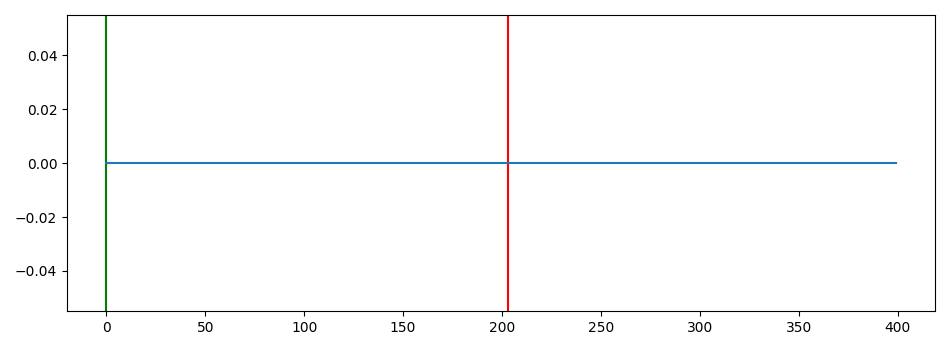

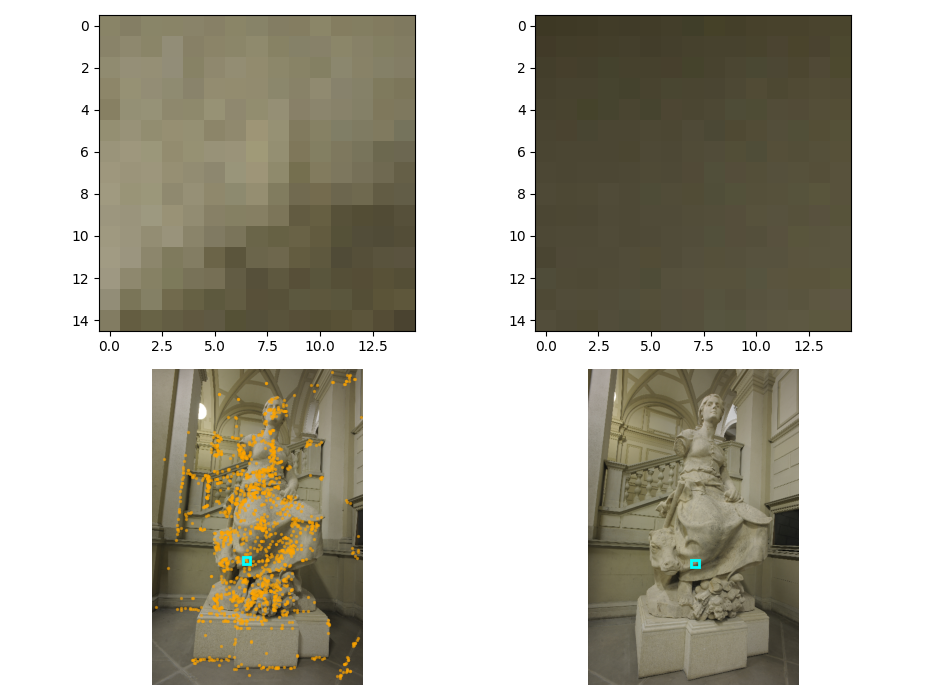

In [11]:
pc_functions = {
    "SSD": photo_consistency_SSD,
    "SAD": photo_consistency_SAD,
    "NCC": photo_consistency_NCC,
}

mvs.plot_photoconsistency_along_ray(image0, image1, camera0, camera1, points2D_0, points3D, pc_functions)

In [12]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Photo consistency accuracy
To get a better idea of how the photo consistency measures perform overall we compare the results for all known 3D points. The following percentile graph shows the percentage of points whose photo consistency peak lies within a certain distance of the correct pixel (distance measured in pixels in an image). Note that a photo consistency measure is not perfect: not all pixels will match to the correct points.

interactive(children=(Dropdown(description='Photo Consistency Measure', options=('SSD', 'SAD', 'NCC'), value='…

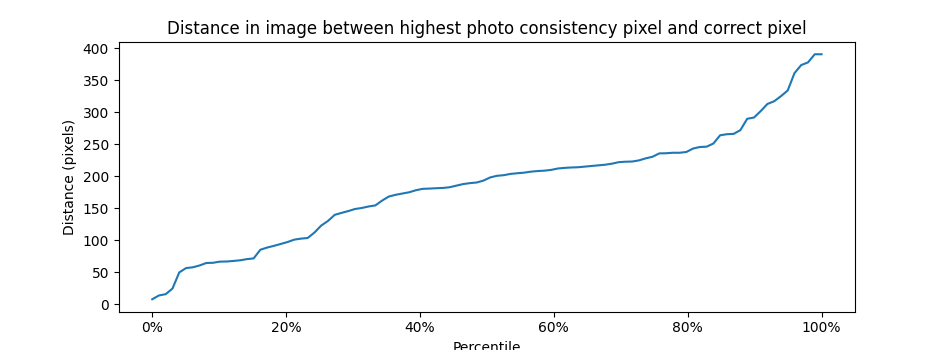

In [13]:
mvs.plot_photoconsistency_accuracy(image0, image1, camera0, camera1, points2D_0[:100], points2D_1[:100], points3D, pc_functions)

## Interactive Photoconsistency Demo
The following live demo shows everything in action. **Click anywhere in the left image** and the program will automatically compute and draw the photo consistency along the epipolar line in the right image. It will also highlight the pixel with the highest photo consistency measure.

interactive(children=(Dropdown(description='Photo Consistency Measure', options=('SSD', 'SAD', 'NCC'), value='…

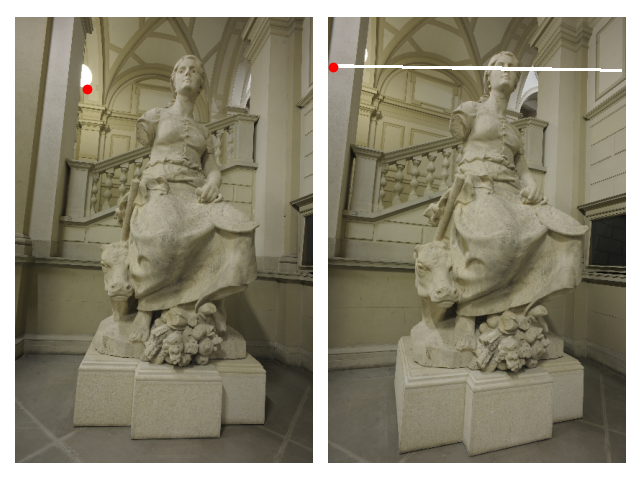

In [14]:
mvs.plot_epipolar_line_with_photoconsistency(image0, image1, camera0, camera1, 0.1, 10.0, pc_functions, closest_point_between_rays)

## Complete 3D reconstruction
The following function will perform a 3D reconstruction using the building blocks that you have implemented. To reduce the potential error, points that lie unrealistically close or far (`min_distance`/`max_distance`) are considered incorrect matches (outliers) and are discarded. Furthermore, when displaying the 3D point cloud we use a (manually created) image mask to hide background pixels. You can view the full code (and modify it as you wish) in `mvs.py`.

You are encouraged to try different support domain sizes, photo consistency functions and input image resolutions.

**NOTE** This is a very computationally intensive process which can take a couple of minutes to complete.

  0% (0 of 543) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (21 of 543) |                       | Elapsed Time: 0:00:00 ETA:   0:00:01
  7% (42 of 543) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:01
 12% (69 of 543) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 16% (90 of 543) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 21% (117 of 543) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (138 of 543) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 29% (159 of 543) |######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (186 of 543) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 38% (207 of 543) |########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (234 of 543) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 46% (255 of 543) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 51% (282 of 543) |###########          

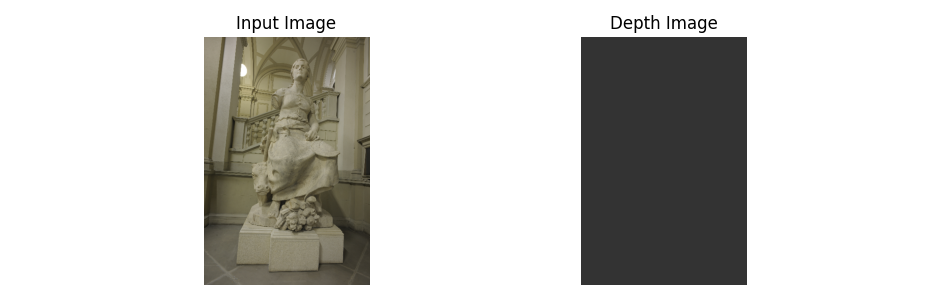

In [15]:
# CHANGE ME
support_domain = 13
photo_consistency_function = photo_consistency_SAD
image_scale = 0.1 # The original image is very high resolution (4138x6208). Scale it down to improve performance.

_, (camera0, camera1), (image0, image1), _ = eth3d_loader.load_eth3d_dataset(
    os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "eth3d", "statue"), ["4", "5"], image_scale, swap_uv=True)
statue_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "eth3d", "statue", "image4_mask.png"), image_scale) > 0.5
statue_mask = np.swapaxes(statue_mask, 0, 1)

# Any points closer/further away from the camera then this distance are considered invalid and will be discarded.
min_distance = 1.8
max_distance = 4.0

estimated_points3D_image = mvs.compute_point_cloud(image0, image1, camera0, camera1, support_domain, photo_consistency_function, closest_point_between_rays, min_distance, max_distance)
mvs.plot_point_cloud(image0, estimated_points3D_image, statue_mask, camera0.pos)